# **SGCN for HGR**

### ◼ __Dependencies__

In [1]:
import random
import torch
import numpy as np

from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import math
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import glob
import seaborn as sns
import sys
import shutil

from mediapipe import solutions

In [2]:
def seed_everything(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(1234)

### ◼ __DEVICE__

In [3]:
class Args:
    ...
    
    def __str__(self):
        return 'Args:\n\t> ' + f'\n\t> '.join([f'{key:.<20}: { val}' for key, val in self.__dict__.items()])
    
    __repr__ = __str__
    
args = Args()

In [4]:
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.device

device(type='cuda')

### ◼ **I. DATASET**

In [5]:
class array2tensor(object):
    """converts a numpy array to a torch tensor"""
        
    def __call__(self, array):
        
        ## numpy: H x W x C => torch: C x H x W
        if len(array.shape) > 3:
            array = array.transpose((0, 3, 1, 2)).astype(np.float32)
        else:
            array = array.transpose((2, 0, 1)).astype(np.float32)
        tensor = torch.from_numpy(array)
        return tensor


def tensor2array(tensor):
    """converts a torch tensor to a numpy array"""
        
    array = tensor.detach().cpu().numpy()
    
    ## torch: C x H x W => numpy: H x W x C
    if len(array.shape) > 3:
        array = array.transpose((0, 2, 3, 1)).astype(np.float32)
    else:
        array = array.transpose((1, 2, 0)).astype(np.float32)
    return array

In [6]:
briareo_labels = ['Fist', 
                  'Pinch',
                  'Flip-over',
                  'Telephone', 
                  'Right swipe', 
                  'Left swipe',
                  'Top-down swipe',
                  'Bottom-up swipe', 
                  'Thumb', 
                  'Index', 
                  'Clockwise rotation',
                  'Counter-clockwise rotation']

(21, 21)


<AxesSubplot: >

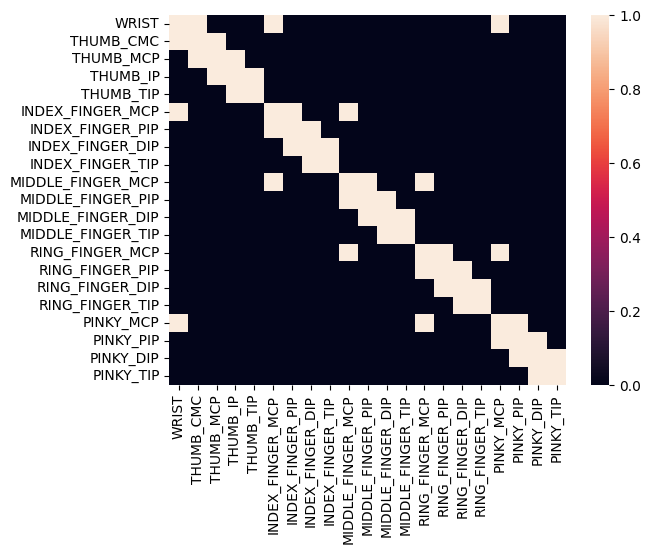

In [7]:
def adj_matrix():
    n_lands = len(solutions.hands.HAND_CONNECTIONS)
    A = np.zeros((n_lands, n_lands))
    for i, j in solutions.hands.HAND_CONNECTIONS:
        A[i][j] = 1.
        A[j][i] = 1.
        
    A += np.eye(A.shape[0])
        
    return A

def get_sgcn_identity(shape):
    identity_spatial = torch.from_numpy(np.array([hand_adj_matrix] * shape[1]*2)).type(torch.float32).to(args.device)
    identity_temporal = torch.triu(torch.ones((shape[2]*2, shape[1], shape[1]), device=args.device), diagonal=1)        
    return [identity_spatial, identity_temporal]

hand_adj_matrix = adj_matrix()
print(hand_adj_matrix.shape)
## display
names = [solutions.hands.HandLandmark(i).name for i in range(21)]
sns.heatmap(hand_adj_matrix, xticklabels=names, yticklabels=names)

In [8]:
solutions.hands.HAND_CONNECTIONS

frozenset({(0, 1),
           (0, 5),
           (0, 17),
           (1, 2),
           (2, 3),
           (3, 4),
           (5, 6),
           (5, 9),
           (6, 7),
           (7, 8),
           (9, 10),
           (9, 13),
           (10, 11),
           (11, 12),
           (13, 14),
           (13, 17),
           (14, 15),
           (15, 16),
           (17, 18),
           (18, 19),
           (19, 20)})

In [9]:
class LandsDataset(Dataset):
    def __init__(self,
                 data_dir, 
                 annotations_file,
                 max_seq_len,
                 labels_encoder=None):
        
        ## data
        self.data_dir = data_dir
        self.annotations_file = annotations_file
        
        ## sequence arguments
        self.max_seq_len = max_seq_len
        self.labels_encoder = labels_encoder
        
        ## moving & static lands
        self.static_lands = [0, 5, 9, 13, 17]
        self.moving_lands = list(set(range(21)) - set(self.static_lands))
        
        self.lambda_moving = 10
        self.lambda_static = 3
        self.lambda_global = 1
        
        self.num_connections = {land:0 for land in range(21)}
        for i, j in solutions.hands.HAND_CONNECTIONS:
            self.num_connections[i] += 1

        ## load all sequences paths
        # self.data = self.get_sequences_ipn_paths()   
        self.data = self.get_sequences_briareo_paths() 
        # self.data = self.get_sequences_jester_paths()   
    
    def get_sequences_ipn_paths(self):
        
        with open(self.annotations_file) as f:
            annotations = f.readlines()
            
        annotations = [annot.strip().split(',') for annot in annotations]
            
        data = []
        labels_count = {label:0 for label in ipn_labels_encoding}
        for  video, label, id_, t_start, t_end, frames in tqdm(annotations, desc='loading landamrks....'):

            if label == 'D0X' and labels_count[label] > 200:
                if 'Train' in self.annotations_file:
                    continue
            file_name = '_'.join(list(map(str, [label, id_, t_start, t_end, frames]))) + '.txt'
            file_path = os.path.join(self.data_dir, video, file_name)
            if not os.path.exists(file_path):
                #print(file_path)
                continue
            labels_count[label] += 1
            landmarks = self.load_landmarks(file_path)
            if landmarks is not None:
                if self.labels_encoder:
                    label = self.labels_encoder[label]
                data.append((landmarks, label))
        return data
    
    def get_sequences_briareo_paths(self):

        files = []
        for ele in np.load(self.annotations_file, allow_pickle=True).values():
            for d in ele:
                seq = d['data']
                seq_path = os.path.join(*seq[0].split('/')[:-2])
                files.append((os.path.join(self.data_dir, seq_path), d['label']))
            
        data = []
        for seq_path, label in tqdm(files, desc='loading landamrks....'):
            file_path = os.path.join(seq_path, os.listdir(seq_path)[0])
            landmarks = self.load_landmarks(file_path)
            if landmarks is not None:
                data.append((landmarks, label))
        return data
    
    
    def load_landmarks(self, txt_file):
        sequence_landmarks = []
        with open(txt_file) as f:
            data = f.read()
            
        sequence = data.split('\n\n')
        for frame in sequence:
            lines = frame.split('\n')
            landmarks = []
            for e, line in enumerate(lines):
                
                if len(line) == 1:
                    coords = [-1.0, -1.0, -1.0, -1.0]
                else:
                    coords = line.split(';')
                    coords = list(filter(lambda x: len(x), coords))
                    coords = [self.num_connections[e]/3] + [float(x) for x in coords]
                #spher_coords = self.cartesian_to_polar(coords)
                landmarks.append(coords)
                
            if len(landmarks) < 2:
                continue
                #landmarks = [[-1.0, -1.0, -1.0, -1.0]] * 21
                
            landmarks = np.array(landmarks).astype(np.float32)
            speed, accel = self.compute_motion_features(landmarks)
            features = np.hstack((landmarks, speed, accel))
            sequence_landmarks.append(features)
            
        if len(sequence_landmarks) > 1:
            sequence_landmarks = np.array(sequence_landmarks).astype(np.float32)
            sequence_landmarks = self.normalize_sequence_length(sequence_landmarks, self.max_seq_len)
            return sequence_landmarks
        return None
  
    def __len__(self):
        return len(self.data)
    
    def cartesian_to_spherical(self, coords):
        x, y, z = coords
        r = np.sqrt(x**2 + y**2 + z**2)
        theta = np.arccos(z / r)
        phi = np.arctan2(y, x)
        return [r, theta, phi]

    def cartesian_to_polar(self, coords):
        x, y = coords
        r = np.sqrt(x**2 + y**2)
        theta = np.arctan2(y, x)
        return [r, theta]
    
    def top_k(self, array, k):
        flat = array.flatten()
        indices = np.argpartition(flat, -k)[-k:]
        indices = indices[np.argsort(-flat[indices])]
        return np.sort(np.unravel_index(indices, array.shape))

    def get_delta(self, landmarks):
        delta_moving = np.mean(landmarks[1:, self.moving_lands, :3] - landmarks[:-1, self.moving_lands, :3], axis=(1, 2))
        delta_static = np.mean(landmarks[1:, self.static_lands, :3] - landmarks[:-1, self.static_lands, :3], axis=(1, 2))
        delta_global = np.mean(landmarks[1:, :, :3] - landmarks[:-1, :, :3], axis=(1, 2))
        
        delta = self.lambda_moving * delta_moving + self.lambda_static * delta_static + self.lambda_global * delta_global
        delta = np.concatenate(([0], delta))
        
        return delta
        
    
    def interpolate_landmarks(self, landmarks, L):
        l, n_landmarks, _ = landmarks.shape
        assert l > 1, "The sequence of landmarks should have at least two landmarks"

        # Compute the indices of the input landmarks
        input_indices = np.linspace(0, l - 1, l, dtype=int)

        # Compute the indices of the output landmarks
        output_indices = np.linspace(0, l - 1, L, dtype=float)

        # Compute the fractional part of the output indices
        fractions = output_indices % 1

        # Compute the integer part of the output indices
        output_indices = np.floor(output_indices).astype(int)

        # Initialize the output array
        interpolated_landmarks = np.zeros((L, n_landmarks, 6), dtype=float)

        # Compute the interpolated landmarks
        for i in range(L):
            if fractions[i] == 0:
                # The output index corresponds to an input landmark, so just copy it
                interpolated_landmarks[i] = landmarks[input_indices[output_indices[i]]]
            else:
                # Compute the mean vector between the two nearest input landmarks
                v1 = landmarks[input_indices[output_indices[i]]]
                v2 = landmarks[input_indices[min(output_indices[i] + 1, l - 1)]]
                interpolated_landmarks[i] = np.mean([v1, v2], axis=0)

        return interpolated_landmarks

    def compute_motion_features(self, lm):
        # Compute motion features from hand gesture landmarks
        # lm is a 3D numpy array of shape (n, 3), where n is the number of landmarks

        # Calculate the velocity vectors between each set of consecutive landmarks
        v = lm[1:] - lm[:-1]

        # Calculate the lengths of each velocity vector
        d = np.linalg.norm(v, axis=1)

        # Calculate the time differences between each pair of consecutive landmarks
        t = np.arange(len(lm))
        dt = t[1:] - t[:-1]

        # Calculate the speed and acceleration between each set of consecutive landmarks
        speed = d / dt
        accel = speed[1:] - speed[:-1]

        # Add 0 as the first speed and acceleration (since there is no previous velocity vector to compare with)
        speed = np.concatenate(([0], speed)).reshape(-1, 1)
        accel = np.concatenate(([0, 0], accel)).reshape(-1, 1)

        return speed, accel
    
    def normalize_sequence_length(self, sequence, max_length):
        """
        """
        if len(sequence) > max_length:
            delta = self.get_delta(sequence)
            norm_sequence = sequence[self.top_k(delta, max_length)][0]
            
        elif len(sequence) < max_length:
            norm_sequence = self.interpolate_landmarks(sequence, max_length)
        else:
            norm_sequence = sequence
        
        return norm_sequence
    
    
    def __getitem__(self, index):
        
        ## get files paths
        landmarks, label = self.data[index]

        ## covert data to tensors
        landmarks = torch.from_numpy(landmarks).type(torch.float32)
        label = torch.tensor(label).type(torch.long)

        return landmarks, label

In [10]:
## paths
args.data_dir = '/home/hichemsaoudi/Downloads/Briareo_landmarks_splits/landmarks'
args.train_annot_file = '/home/hichemsaoudi/Downloads/Briareo_landmarks_splits/splits/train/depth_train.npz'
args.valid_annot_file = '/home/hichemsaoudi/Downloads/Briareo_landmarks_splits/splits/train/depth_val.npz'
args.test_annot_file  = '/home/hichemsaoudi/Downloads/Briareo_landmarks_splits/splits/test/depth_test.npz'

args.use_data_aug = False
## params
args.num_nodes = 21
args.max_seq_len = 60
args.labels_encoder = None
train_dataset = LandsDataset(args.data_dir,
                           args.train_annot_file,
                           args.max_seq_len,
                           #use_data_aug = True,
                          )


valid_dataset = LandsDataset(args.data_dir,
                           args.valid_annot_file,
                           args.max_seq_len,
                           #use_data_aug = args.use_data_aug,
                          )

test_dataset = LandsDataset(args.data_dir,
                          args.test_annot_file,
                          args.max_seq_len,
                          #use_data_aug = args.use_data_aug
                         )

loading landamrks....: 100%|█████████████████| 288/288 [00:01<00:00, 278.56it/s]


In [11]:
sample = train_dataset[200]
print(len(train_dataset[0]))
data,label = sample
print(data.shape)

2
torch.Size([60, 21, 6])


In [12]:
args.num_classes = len(set([y for _, y in train_dataset.data]))

args.batch_size = 1

train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)#, pin_memory=True, num_workers=12)
valid_dataloader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False)#, pin_memory=True, num_workers=12)
test_dataloader  = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)#, pin_memory=True, num_workers=12)

len(train_dataloader), len(valid_dataloader), len(test_dataloader)

(936, 216, 288)

In [13]:
args.num_classes

12

### ◼ **II. MODEL**

In [14]:
def reset_parameters_linear(layer): 
    torch.nn.init.kaiming_uniform_(layer.weight, a=np.sqrt(5)) 
    if layer.bias is not None: 
        fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(layer.weight) 
        bound = 1 / np.sqrt(fan_in) 
        torch.nn.init.uniform_(layer.bias, -bound, bound) 

In [15]:
class AsymmetricConvolution(nn.Module):

    def __init__(self, in_cha, out_cha):
        super(AsymmetricConvolution, self).__init__()

        self.conv1 = nn.Conv2d(in_cha, out_cha, kernel_size=(3, 1), padding=(1, 0), bias=False)
        self.conv2 = nn.Conv2d(in_cha, out_cha, kernel_size=(1, 3), padding=(0, 1))

        self.shortcut = nn.Identity()

        if in_cha != out_cha:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_cha, out_cha, 1, bias=False)
            )

        self.activation = nn.PReLU()

    def forward(self, x):

        shortcut = self.shortcut(x)

        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x2 = self.activation(x2 + x1)

        return x2 + shortcut


class InteractionMask(nn.Module):

    def __init__(self, n_asymmetric_convs, spatial_channels, temporal_channels):
        super(InteractionMask, self).__init__()

        self.n_asymmetric_convs = n_asymmetric_convs

        self.spatial_asymmetric_convolutions = nn.ModuleList()
        self.temporal_asymmetric_convolutions = nn.ModuleList()

        for i in range(self.n_asymmetric_convs):
            self.spatial_asymmetric_convolutions.append(
                AsymmetricConvolution(spatial_channels, spatial_channels)
            )
            self.temporal_asymmetric_convolutions.append(
                AsymmetricConvolution(temporal_channels, temporal_channels)
            )

        self.spatial_output = nn.Sigmoid()
        self.temporal_output = nn.Sigmoid()

    def forward(self, dense_spatial_interaction, dense_temporal_interaction, threshold=0.5):

        assert len(dense_temporal_interaction.shape) == 4
        assert len(dense_spatial_interaction.shape) == 4

        for j in range(self.n_asymmetric_convs):
            dense_spatial_interaction = self.spatial_asymmetric_convolutions[j](dense_spatial_interaction)
            dense_temporal_interaction = self.temporal_asymmetric_convolutions[j](dense_temporal_interaction)

        spatial_interaction_mask = self.spatial_output(dense_spatial_interaction)
        temporal_interaction_mask = self.temporal_output(dense_temporal_interaction)

        spatial_zero = torch.zeros_like(spatial_interaction_mask, device=dense_spatial_interaction.device)
        temporal_zero = torch.zeros_like(temporal_interaction_mask, device=dense_temporal_interaction.device)

        spatial_interaction_mask = torch.where(spatial_interaction_mask > threshold, spatial_interaction_mask,
                                               spatial_zero)

        temporal_interaction_mask = torch.where(temporal_interaction_mask > threshold, temporal_interaction_mask,
                                               temporal_zero)

        return spatial_interaction_mask, temporal_interaction_mask


class ZeroSoftmax(nn.Module):

    def __init__(self):
        super(ZeroSoftmax, self).__init__()

    def forward(self, x, dim=0, eps=1e-5):
        x_exp = torch.pow(torch.exp(x) - 1, exponent=2)
        x_exp_sum = torch.sum(x_exp, dim=dim, keepdim=True)
        x = x_exp / (x_exp_sum + eps)
        return x


class SelfAttention(nn.Module):

    def __init__(self, in_dims, d_model, n_heads):
        super(SelfAttention, self).__init__()

        self.embedding = nn.Linear(in_dims, d_model)
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)

        self.scaled_factor = torch.sqrt(torch.Tensor([d_model])).to(args.device)
        self.softmax = nn.Softmax(dim=-1)

        self.n_heads = n_heads
        
        reset_parameters_linear(self.embedding)
        reset_parameters_linear(self.query)
        reset_parameters_linear(self.key)

    def split_heads(self, x):

        x = x.reshape(x.shape[0], -1, self.n_heads, x.shape[-1] // self.n_heads).contiguous()

        return x.permute(0, 2, 1, 3) 

    def forward(self, x, mask=False, multi_head=False):

        assert len(x.shape) == 3

        embeddings = self.embedding(x)  
        query = self.query(embeddings) 
        key = self.key(embeddings)   

        if multi_head:
            query = self.split_heads(query)  
            key = self.split_heads(key) 
            attention = torch.matmul(query, key.permute(0, 1, 3, 2))  
        else:
            attention = torch.matmul(query, key.permute(0, 2, 1))

        attention = self.softmax(attention / self.scaled_factor)

        if mask is True:

            mask = torch.ones_like(attention)
            attention = attention * torch.tril(mask)

        return attention, embeddings

    
class SpatialTemporalFusion(nn.Module):

    def __init__(self, n_frames):
        super(SpatialTemporalFusion, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(n_frames, n_frames, 1),
            nn.BatchNorm2d(n_frames),
            nn.PReLU(),
            nn.Conv2d(n_frames, n_frames, 1),
            nn.BatchNorm2d(n_frames)
        )

        self.shortcut = nn.Sequential(
            nn.Conv2d(n_frames, n_frames, 1),
            nn.BatchNorm2d(n_frames)
        )

    def forward(self, x):

        out = self.conv(x)
        out += self.shortcut(x)

        out = F.relu(out)

        return out.squeeze()


class SparseWeightedAdjacency(nn.Module):

    def __init__(self, spa_in_dims, tem_in_dims, embedding_dims, n_heads, n_frames, dropout, n_asymmetric_convs):
        super(SparseWeightedAdjacency, self).__init__()

        # positional encoder
        #self.positional_encoder = PositionalEncoder(embedding_dims)
        self.pes = PositionalEncoding (channel = 6, joint_num = 21, time_len = 60, domain = "spatial")
        self.pet = PositionalEncoding (channel = 6, joint_num = 21, time_len = 60, domain = "temporal")

        ##Regulation
        #self.attention0s = nn.Parameter(torch.zeros(1, n_heads, 21, 21) + torch.eye(21),
                                                #requires_grad=True)
        # dense interaction
        self.spatial_attention = SelfAttention(spa_in_dims, embedding_dims, n_heads)
        self.temporal_attention = SelfAttention(tem_in_dims, embedding_dims, n_heads)

        # attention fusion
        self.spa_fusion = SpatialTemporalFusion(n_frames=n_frames)

        # interaction mask
        self.interaction_mask = InteractionMask(n_asymmetric_convs=n_asymmetric_convs,
                                                spatial_channels=4,
                                                temporal_channels=4)

        self.dropout = dropout
        self.zero_softmax = ZeroSoftmax()

    def forward(self, graph, identity):

        assert len(graph.shape) == 3


        spatial_graph = graph[:, :, :]
        
        temporal_graph_emb = spatial_graph.permute(1, 0, 2)

        spatial_graph_emb = self.pet(spatial_graph)

        #temporal_graph = self.pet(spatial_graph)

        

        dense_spatial_interaction, spatial_embeddings = self.spatial_attention(spatial_graph_emb, multi_head=True)
        
        dense_temporal_interaction, temporal_embeddings = self.temporal_attention(temporal_graph_emb, multi_head=True)
        
        #dense_spatial_interaction = dense_spatial_interaction + self.attention0s.repeat(60, 1, 1, 1)

        # attention fusion
        st_interaction = self.spa_fusion(dense_spatial_interaction.permute(1, 0, 2, 3)).permute(1, 0, 2, 3)
        ts_interaction = dense_temporal_interaction
        spatial_mask, temporal_mask = self.interaction_mask(st_interaction, ts_interaction)

        # self-connected
        spatial_mask = spatial_mask + identity[0].unsqueeze(1)
        temporal_mask = temporal_mask + identity[1].unsqueeze(1)

        normalized_spatial_adjacency_matrix = self.zero_softmax(dense_spatial_interaction * spatial_mask, dim=-1)
        normalized_temporal_adjacency_matrix = self.zero_softmax(dense_temporal_interaction * temporal_mask, dim=-1)

        return normalized_spatial_adjacency_matrix, normalized_temporal_adjacency_matrix,\
               spatial_embeddings, temporal_embeddings
    


class GraphConvolution(nn.Module):

    def __init__(self, in_dims, embedding_dims, dropout):
        super(GraphConvolution, self).__init__()

        self.embedding = nn.Linear(in_dims, embedding_dims, bias=False)
        self.activation = nn.PReLU()

        self.dropout = dropout
        
        reset_parameters_linear(self.embedding)

    def forward(self, graph, adjacency):

        gcn_features = self.embedding(torch.matmul(adjacency, graph))
        gcn_features = F.dropout(self.activation(gcn_features), p=self.dropout)
        return gcn_features


class SparseGraphConvolution(nn.Module):

    def __init__(self, in_dims, embedding_dims, dropout):
        super(SparseGraphConvolution, self).__init__()

        self.dropout = dropout

        self.spatial_temporal_sparse_gcn = nn.ModuleList()
        self.temporal_spatial_sparse_gcn = nn.ModuleList()

        self.spatial_temporal_sparse_gcn.append(GraphConvolution(in_dims, embedding_dims, dropout=dropout))
        self.spatial_temporal_sparse_gcn.append(GraphConvolution(embedding_dims, embedding_dims, dropout=dropout))

        self.temporal_spatial_sparse_gcn.append(GraphConvolution(in_dims, embedding_dims, dropout=dropout))
        self.temporal_spatial_sparse_gcn.append(GraphConvolution(embedding_dims, embedding_dims, dropout=dropout))
        

    def forward(self, graph, normalized_spatial_adjacency_matrix, normalized_temporal_adjacency_matrix):
        
        spa_graph = graph.permute(1, 0, 2, 3) 
        tem_graph = spa_graph.permute(2, 1, 0, 3)
        
        gcn_spatial_features = self.spatial_temporal_sparse_gcn[0](spa_graph, normalized_spatial_adjacency_matrix)
        gcn_spatial_features = gcn_spatial_features.permute(2, 1, 0, 3)

        gcn_spatial_temporal_features = self.spatial_temporal_sparse_gcn[1](gcn_spatial_features, normalized_temporal_adjacency_matrix)

        gcn_temporal_features = self.temporal_spatial_sparse_gcn[0](tem_graph,
                                                                   normalized_temporal_adjacency_matrix)
        gcn_temporal_features = gcn_temporal_features.permute(2, 1, 0, 3)
        gcn_temporal_spatial_features = self.temporal_spatial_sparse_gcn[1](gcn_temporal_features,
                                                                            normalized_spatial_adjacency_matrix)

        return gcn_spatial_temporal_features, gcn_temporal_spatial_features.permute(2, 1, 0, 3)

class PositionalEncoding(nn.Module):

    def __init__(self, channel, joint_num, time_len, domain):
        super(PositionalEncoding, self).__init__()
        self.joint_num = joint_num
        self.time_len = time_len

        self.domain = domain

        if domain == "temporal":
            # temporal embedding
            pos_list = []
            for t in range(self.time_len):
                for j_id in range(self.joint_num):
                    pos_list.append(t)
        elif domain == "spatial":
            # spatial embedding
            pos_list = []
            for t in range(self.time_len):
                for j_id in range(self.joint_num):
                    pos_list.append(j_id)

        position = torch.from_numpy(np.array(pos_list)).unsqueeze(1).float()
        # pe = position/position.max()*2 -1
        # pe = pe.view(time_len, joint_num).unsqueeze(0).unsqueeze(0)
        # Compute the positional encodings once in log space.
        pe = torch.zeros(self.time_len * self.joint_num, channel)

        div_term = torch.exp(torch.arange(0, channel, 2).float() *
                             -(math.log(10000.0) / channel))  # channel//2
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.view(time_len, joint_num, channel).squeeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):  # nctv
        x = x + self.pe[:, :, :x.size(2)]
        return x

class SGCNModel(nn.Module):

    def __init__(self, args):
        super(SGCNModel, self).__init__()

        self.num_gcn_layers = args.num_gcn_layers
        self.dropout = args.dropout

        ## sparse graph learning
        self.sparse_weighted_adjacency_matrices = SparseWeightedAdjacency(spa_in_dims=args.num_features,
                                                                          tem_in_dims=args.num_features,
                                                                          embedding_dims=args.embedding_dims,
                                                                          n_heads=args.num_heads,
                                                                          n_frames=args.max_seq_len,
                                                                          dropout=args.dropout,
                                                                          n_asymmetric_convs=args.num_asymmetric_convs)

        ## graph convolution
        self.stsgcn = nn.ModuleList()
        for _ in range(args.num_gcn_layers):
            self.stsgcn.append(SparseGraphConvolution(in_dims=args.num_features, 
                                                 embedding_dims=args.embedding_dims // args.num_heads,
                                                 dropout=args.dropout))
        
        self.fusion_ = nn.Conv2d(args.num_heads, args.num_heads, kernel_size=1, bias=False)

        ## spatial & temoral edges weights
        self.temporal_edge_weights = nn.Sequential(nn.Linear(args.num_features, args.num_heads, bias=True),
                                                   nn.Linear(args.num_heads, args.num_heads*args.max_seq_len, bias=True))
        
        self.spatial_edge_weights  = nn.Sequential(nn.Linear(args.num_features, args.num_heads, bias=True),
                                                   nn.Linear(args.num_heads, args.num_heads*args.num_nodes, bias=True))
        ## adaptive pooling
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, args.num_heads))
        
        ## MLP
        self.mlp = nn.Sequential(
            nn.Flatten(start_dim=0),
            nn.Linear((args.embedding_dims * args.num_nodes  * args.max_seq_len) // args.num_heads, 512),
            nn.PReLU(),
            nn.Dropout(args.dropout),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.Dropout(args.dropout),
            nn.Linear(128, args.num_classes)
        )


    def forward(self, graph, identity):

        # graph 1 obs_len N 3

        normalized_spatial_adjacency_matrix, normalized_temporal_adjacency_matrix, spatial_embeddings, temporal_embeddings = \
            self.sparse_weighted_adjacency_matrices(graph.squeeze(), identity)
        
        #W_spatio = self.spatial_edge_weights(graph)
        #W_spatio = W_spatio.reshape(normalized_spatial_adjacency_matrix.shape)
        
        #W_tempo = self.temporal_edge_weights(graph)
        #W_tempo = W_tempo.reshape(normalized_temporal_adjacency_matrix.shape)
        
        #weighted_normalized_spatial_adjacency_matrix  = normalized_spatial_adjacency_matrix * W_spatio
        #weighted_normalized_temporal_adjacency_matrix = normalized_temporal_adjacency_matrix * W_tempo
        
        for layer in self.stsgcn:
            gcn_temporal_spatial_features, gcn_spatial_temporal_features = layer(
                graph, normalized_spatial_adjacency_matrix, normalized_temporal_adjacency_matrix
            )

        gcn_representation = self.fusion_(gcn_temporal_spatial_features) + gcn_spatial_temporal_features
        gcn_representation = gcn_representation.permute(0, 2, 1, 3)
        gcn_representation = torch.mean(gcn_representation, dim=-2)
                
        prediction = self.mlp(gcn_representation)

        return prediction.unsqueeze(dim=0), gcn_representation, normalized_spatial_adjacency_matrix, normalized_temporal_adjacency_matrix

### ◼ **III. TRAIN**

In [17]:
import time
def train_epoch(epoch, num_epochs, model, optimizer, dataloader, criterion):
    model.train()

    pbar = tqdm(dataloader, total=len(dataloader))
    total_loss = 0

    for (V, y) in pbar:
        V = V.to(args.device)
        y = y.to(args.device)
        identity = get_sgcn_identity(V.shape)
        optimizer.zero_grad()
        pred, _, pred_spatial_adj, _ = model(V, identity)
        loss_train = criterion(pred, y)
        loss_train.backward()
        optimizer.step()
        total_loss += loss_train.item()
        pbar.set_description(f'[%.2g/%.2g] train loss. %.2f' % (epoch, num_epochs, total_loss/len(y)))
    scheduler.step()
    
    return total_loss
        
def validate_epoch(model, dataloader, criterion):
    acc = 0.0
    n = 0
    pred_labels, true_labels = [], []
    total_loss = 0.0
    model.eval()
    start_time = time.time()  # Record the start time
    
    with torch.no_grad():
        pbar = tqdm(dataloader, total=len(dataloader))
        for (V, y) in pbar:
            V = V.to(args.device)
            y = y.to(args.device)
            true_labels.append(y[0].item())
            identity = get_sgcn_identity(V.shape)
            output, *_ = model(V, identity)
            loss_valid = criterion(output, y)
            acc += (output.argmax(dim=1) == y.flatten()).sum().item()
            n += len(y.flatten())
            total_loss += loss_valid.item()
            
            pred_labels.append(output.argmax(dim=1)[0].item())
            desc = '[VALID]> loss. %.2f > acc. %.2g%%' % (total_loss/len(y), (acc / n)*100)
            pbar.set_description(desc)
        
    elapsed_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Validation time: {elapsed_time:.2f} seconds")
                
    return total_loss, true_labels, pred_labels

In [18]:
args.num_epochs = 200

## model parameters
args.num_features = 5 + 1
args.num_asymmetric_convs = 3
args.embedding_dims = 64
args.num_gcn_layers = 1
args.num_heads = 4
args.dropout = 0.5

## optimizer parameters
args.lr = 1e-3
args.weight_decay = 5e-2
args.T_max = 20

## save models path
args.save_path = "/home/hichemsaoudi/Desktop/brifinal2"
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path, exist_ok=True)

args

Args:
	> device..............: cuda
	> data_dir............: /home/hichemsaoudi/Downloads/Briareo_landmarks_splits/landmarks
	> train_annot_file....: /home/hichemsaoudi/Downloads/Briareo_landmarks_splits/splits/train/depth_train.npz
	> valid_annot_file....: /home/hichemsaoudi/Downloads/Briareo_landmarks_splits/splits/train/depth_val.npz
	> test_annot_file.....: /home/hichemsaoudi/Downloads/Briareo_landmarks_splits/splits/test/depth_test.npz
	> use_data_aug........: False
	> num_nodes...........: 21
	> max_seq_len.........: 60
	> labels_encoder......: None
	> use_T...............: False
	> num_classes.........: 12
	> batch_size..........: 1
	> num_epochs..........: 200
	> num_features........: 6
	> num_asymmetric_convs: 3
	> embedding_dims......: 64
	> num_gcn_layers......: 1
	> num_heads...........: 4
	> dropout.............: 0.5
	> lr..................: 0.001
	> weight_decay........: 0.05
	> T_max...............: 20
	> save_path...........: /home/hichemsaoudi/Desktop/brifinal2

In [20]:
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn

## build model
sgcn = SGCNModel(args)

optimizer = optim.AdamW(sgcn.parameters(), lr=args.lr, weight_decay=args.weight_decay)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.T_max, eta_min=0, last_epoch=-1, verbose=False)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

## to device
sgcn = nn.DataParallel(sgcn).to(args.device)

best_val = float("inf")


# Training loop
losses = []
accuracies = []

# Initialize a variable to track the best validation loss
best_val_loss = float('inf')

# Training loop
for epoch in range(1, args.num_epochs+1):
    train_loss = train_epoch(epoch, args.num_epochs, sgcn, optimizer, train_dataloader, criterion)
    valid_loss, true_labels, pred_labels = validate_epoch(sgcn, valid_dataloader, criterion)
    
    # Calculate accuracy
    correct = sum([1 for true, pred in zip(true_labels, pred_labels) if true == pred])
    accuracy = correct / len(true_labels)

    losses.append(valid_loss)
    accuracies.append(accuracy)
    
    if valid_loss < best_val_loss:
        # Update the best validation loss
        best_val_loss = valid_loss
        
        # Save the current best model
        save_checkpoint({'epoch': epoch,
                         'state_dict': sgcn.module.state_dict(),
                         'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(),
                         'best_loss': best_val_loss},
                        args.save_path, 'bestmodel.pth', True)

[VALID]> loss. 497.02 > acc. 20%: 100%|███████| 216/216 [00:02<00:00, 98.81it/s]


Validation time: 2.19 seconds


[VALID]> loss. 273.86 > acc. 64%: 100%|██████| 216/216 [00:01<00:00, 110.01it/s]


Validation time: 1.96 seconds


[VALID]> loss. 242.95 > acc. 71%: 100%|██████| 216/216 [00:01<00:00, 117.04it/s]


Validation time: 1.85 seconds


[VALID]> loss. 218.69 > acc. 75%: 100%|██████| 216/216 [00:02<00:00, 106.45it/s]


Validation time: 2.03 seconds


[6/2e+02] train loss. 6.30:   0%|               | 4/936 [00:00<00:42, 21.77it/s]

Validation time: 2.11 seconds


[VALID]> loss. 212.78 > acc. 79%: 100%|██████| 216/216 [00:02<00:00, 101.71it/s]


Validation time: 2.12 seconds


[VALID]> loss. 195.99 > acc. 82%: 100%|███████| 216/216 [00:02<00:00, 91.87it/s]


Validation time: 2.35 seconds


[VALID]> loss. 184.07 > acc. 83%: 100%|██████| 216/216 [00:02<00:00, 100.42it/s]


Validation time: 2.15 seconds


[VALID]> loss. 180.38 > acc. 84%: 100%|██████| 216/216 [00:02<00:00, 102.50it/s]


Validation time: 2.11 seconds


[VALID]> loss. 176.75 > acc. 88%: 100%|███████| 216/216 [00:02<00:00, 95.91it/s]


Validation time: 2.25 seconds


[VALID]> loss. 168.19 > acc. 86%: 100%|███████| 216/216 [00:02<00:00, 98.48it/s]


Validation time: 2.19 seconds


[13/2e+02] train loss. 3.98:   0%|              | 3/936 [00:00<00:54, 17.03it/s]

Validation time: 2.18 seconds


[14/2e+02] train loss. 4.15:   0%|              | 3/936 [00:00<00:58, 15.94it/s]

Validation time: 2.29 seconds


[VALID]> loss. 163.89 > acc. 88%: 100%|███████| 216/216 [00:02<00:00, 95.58it/s]


Validation time: 2.26 seconds


[16/2e+02] train loss. 3.63:   0%|              | 4/936 [00:00<00:44, 20.79it/s]

Validation time: 2.14 seconds


[VALID]> loss. 158.52 > acc. 88%: 100%|███████| 216/216 [00:02<00:00, 98.32it/s]


Validation time: 2.20 seconds


[18/2e+02] train loss. 3.19:   0%|              | 3/936 [00:00<01:01, 15.18it/s]

Validation time: 2.34 seconds


[19/2e+02] train loss. 4.69:   0%|              | 3/936 [00:00<00:59, 15.58it/s]

Validation time: 2.44 seconds


[20/2e+02] train loss. 4.72:   0%|              | 4/936 [00:00<00:39, 23.50it/s]

Validation time: 2.13 seconds


[21/2e+02] train loss. 3.14:   0%|              | 3/936 [00:00<00:56, 16.55it/s]

Validation time: 2.15 seconds


[22/2e+02] train loss. 3.59:   0%|              | 3/936 [00:00<00:58, 15.94it/s]

Validation time: 2.17 seconds


[23/2e+02] train loss. 2.84:   0%|              | 3/936 [00:00<00:53, 17.52it/s]

Validation time: 2.23 seconds


[VALID]> loss. 158.10 > acc. 90%: 100%|███████| 216/216 [00:02<00:00, 95.47it/s]


Validation time: 2.26 seconds


[25/2e+02] train loss. 2.83:   0%|              | 3/936 [00:00<00:57, 16.26it/s]

Validation time: 2.15 seconds


[VALID]> loss. 158.04 > acc. 91%: 100%|██████| 216/216 [00:02<00:00, 101.06it/s]


Validation time: 2.14 seconds


[27/2e+02] train loss. 4.05:   0%|              | 4/936 [00:00<00:41, 22.38it/s]

Validation time: 2.20 seconds


[28/2e+02] train loss. 3.64:   0%|              | 3/936 [00:00<01:00, 15.45it/s]

Validation time: 2.38 seconds


[VALID]> loss. 157.37 > acc. 90%: 100%|███████| 216/216 [00:02<00:00, 96.14it/s]


Validation time: 2.25 seconds


[30/2e+02] train loss. 3.07:   0%|              | 3/936 [00:00<01:00, 15.55it/s]

Validation time: 2.13 seconds


[31/2e+02] train loss. 2.86:   0%|              | 3/936 [00:00<00:58, 15.86it/s]

Validation time: 2.06 seconds


[32/2e+02] train loss. 4.53:   0%|              | 4/936 [00:00<00:44, 20.91it/s]

Validation time: 2.23 seconds


[33/2e+02] train loss. 4.84:   0%|              | 4/936 [00:00<00:43, 21.65it/s]

Validation time: 2.19 seconds


[34/2e+02] train loss. 3.87:   0%|              | 4/936 [00:00<00:45, 20.57it/s]

Validation time: 2.13 seconds


[35/2e+02] train loss. 5.24:   0%|              | 3/936 [00:00<00:57, 16.21it/s]

Validation time: 2.14 seconds


[36/2e+02] train loss. 2.47:   0%|              | 3/936 [00:00<00:48, 19.12it/s]

Validation time: 2.24 seconds


[37/2e+02] train loss. 3.54:   0%|              | 4/936 [00:00<00:39, 23.35it/s]

Validation time: 2.10 seconds


[38/2e+02] train loss. 2.89:   0%|              | 3/936 [00:00<00:55, 16.88it/s]

Validation time: 2.06 seconds


[39/2e+02] train loss. 3.96:   0%|              | 4/936 [00:00<00:38, 23.98it/s]

Validation time: 2.30 seconds


[40/2e+02] train loss. 3.41:   0%|              | 3/936 [00:00<00:59, 15.65it/s]

Validation time: 2.22 seconds


[41/2e+02] train loss. 2.69:   0%|              | 3/936 [00:00<00:50, 18.62it/s]

Validation time: 2.18 seconds


[42/2e+02] train loss. 3.43:   0%|              | 3/936 [00:00<00:56, 16.63it/s]

Validation time: 2.19 seconds


[43/2e+02] train loss. 4.51:   0%|              | 4/936 [00:00<00:43, 21.29it/s]

Validation time: 2.15 seconds


[44/2e+02] train loss. 3.11:   0%|              | 4/936 [00:00<00:39, 23.76it/s]

Validation time: 2.07 seconds


[VALID]> loss. 156.95 > acc. 94%: 100%|██████| 216/216 [00:02<00:00, 101.61it/s]


Validation time: 2.13 seconds


[VALID]> loss. 155.98 > acc. 94%: 100%|██████| 216/216 [00:02<00:00, 105.23it/s]


Validation time: 2.05 seconds


[47/2e+02] train loss. 3.50:   0%|              | 3/936 [00:00<00:58, 15.83it/s]

Validation time: 2.30 seconds


[VALID]> loss. 150.92 > acc. 94%: 100%|███████| 216/216 [00:02<00:00, 98.60it/s]


Validation time: 2.19 seconds


[VALID]> loss. 146.35 > acc. 95%: 100%|███████| 216/216 [00:02<00:00, 96.66it/s]


Validation time: 2.24 seconds


[50/2e+02] train loss. 3.01:   0%|              | 3/936 [00:00<00:59, 15.78it/s]

Validation time: 2.17 seconds


[51/2e+02] train loss. 3.30:   0%|              | 4/936 [00:00<00:41, 22.30it/s]

Validation time: 2.09 seconds


[52/2e+02] train loss. 3.60:   0%|              | 3/936 [00:00<01:00, 15.41it/s]

Validation time: 2.10 seconds


[53/2e+02] train loss. 3.08:   0%|              | 3/936 [00:00<01:00, 15.45it/s]

Validation time: 2.17 seconds


[54/2e+02] train loss. 3.49:   0%|              | 3/936 [00:00<01:00, 15.41it/s]

Validation time: 2.29 seconds


[55/2e+02] train loss. 3.37:   0%|              | 4/936 [00:00<00:44, 20.91it/s]

Validation time: 2.11 seconds


[56/2e+02] train loss. 2.70:   0%|              | 3/936 [00:00<00:55, 16.92it/s]

Validation time: 2.05 seconds


[57/2e+02] train loss. 3.46:   0%|              | 4/936 [00:00<00:44, 20.83it/s]

Validation time: 2.11 seconds


[58/2e+02] train loss. 4.16:   0%|              | 4/936 [00:00<00:46, 20.25it/s]

Validation time: 2.16 seconds


[59/2e+02] train loss. 2.77:   0%|              | 3/936 [00:00<01:00, 15.43it/s]

Validation time: 2.06 seconds


[60/2e+02] train loss. 3.06:   0%|              | 3/936 [00:00<00:53, 17.45it/s]

Validation time: 2.20 seconds


[61/2e+02] train loss. 2.78:   0%|              | 3/936 [00:00<00:59, 15.64it/s]

Validation time: 2.13 seconds


[62/2e+02] train loss. 3.54:   0%|              | 4/936 [00:00<00:45, 20.43it/s]

Validation time: 2.38 seconds


[VALID]> loss. 144.34 > acc. 94%: 100%|███████| 216/216 [00:02<00:00, 95.51it/s]


Validation time: 2.26 seconds


[64/2e+02] train loss. 3.48:   0%|              | 4/936 [00:00<00:39, 23.45it/s]

Validation time: 2.24 seconds


[65/2e+02] train loss. 2.35:   0%|              | 3/936 [00:00<00:52, 17.69it/s]

Validation time: 2.21 seconds


[66/2e+02] train loss. 2.90:   0%|              | 3/936 [00:00<00:59, 15.58it/s]

Validation time: 2.36 seconds


[67/2e+02] train loss. 2.79:   0%|              | 3/936 [00:00<01:01, 15.16it/s]

Validation time: 2.33 seconds


[68/2e+02] train loss. 2.73:   0%|              | 3/936 [00:00<00:55, 16.74it/s]

Validation time: 2.18 seconds


[69/2e+02] train loss. 2.84:   0%|              | 3/936 [00:00<00:56, 16.64it/s]

Validation time: 2.14 seconds


[70/2e+02] train loss. 3.43:   0%|              | 4/936 [00:00<00:43, 21.53it/s]

Validation time: 2.33 seconds


[71/2e+02] train loss. 3.01:   0%|              | 3/936 [00:00<01:01, 15.20it/s]

Validation time: 2.25 seconds


[72/2e+02] train loss. 2.89:   0%|              | 4/936 [00:00<00:44, 20.79it/s]

Validation time: 2.21 seconds


[73/2e+02] train loss. 3.33:   0%|              | 4/936 [00:00<00:44, 20.87it/s]

Validation time: 2.18 seconds


[74/2e+02] train loss. 3.06:   0%|              | 3/936 [00:00<00:54, 17.02it/s]

Validation time: 2.03 seconds


[75/2e+02] train loss. 1.89:   0%|              | 2/936 [00:00<01:12, 12.81it/s]

Validation time: 2.16 seconds


[76/2e+02] train loss. 2.80:   0%|              | 3/936 [00:00<00:58, 15.99it/s]

Validation time: 2.30 seconds


[77/2e+02] train loss. 2.89:   0%|              | 3/936 [00:00<01:00, 15.54it/s]

Validation time: 2.36 seconds


[78/2e+02] train loss. 3.39:   0%|              | 4/936 [00:00<00:43, 21.47it/s]

Validation time: 2.02 seconds


[79/2e+02] train loss. 3.07:   0%|              | 3/936 [00:00<00:53, 17.42it/s]

Validation time: 2.10 seconds


[80/2e+02] train loss. 3.22:   0%|              | 4/936 [00:00<00:42, 22.10it/s]

Validation time: 2.05 seconds


[81/2e+02] train loss. 2.64:   0%|              | 3/936 [00:00<00:57, 16.09it/s]

Validation time: 1.96 seconds


[82/2e+02] train loss. 3.72:   0%|              | 3/936 [00:00<00:58, 16.00it/s]

Validation time: 1.90 seconds


[83/2e+02] train loss. 2.73:   0%|              | 3/936 [00:00<00:52, 17.88it/s]

Validation time: 1.87 seconds


[84/2e+02] train loss. 3.59:   0%|              | 4/936 [00:00<00:44, 20.75it/s]

Validation time: 2.03 seconds


[85/2e+02] train loss. 3.36:   0%|              | 4/936 [00:00<00:38, 24.46it/s]

Validation time: 2.06 seconds


[86/2e+02] train loss. 3.38:   0%|              | 3/936 [00:00<00:59, 15.57it/s]

Validation time: 1.95 seconds


[87/2e+02] train loss. 2.85:   0%|              | 4/936 [00:00<00:42, 22.17it/s]

Validation time: 2.00 seconds


[88/2e+02] train loss. 3.77:   0%|              | 4/936 [00:00<00:41, 22.43it/s]

Validation time: 2.01 seconds


[89/2e+02] train loss. 3.62:   0%|              | 4/936 [00:00<00:45, 20.57it/s]

Validation time: 2.01 seconds


[90/2e+02] train loss. 3.88:   0%|              | 3/936 [00:00<01:01, 15.17it/s]

Validation time: 2.05 seconds


[91/2e+02] train loss. 3.65:   0%|              | 4/936 [00:00<00:43, 21.20it/s]

Validation time: 1.97 seconds


[92/2e+02] train loss. 1.81:   0%|              | 2/936 [00:00<01:11, 13.06it/s]

Validation time: 1.96 seconds


[93/2e+02] train loss. 2.56:   0%|              | 3/936 [00:00<00:50, 18.46it/s]

Validation time: 1.95 seconds


[VALID]> loss. 143.31 > acc. 94%: 100%|██████| 216/216 [00:01<00:00, 110.35it/s]


Validation time: 1.96 seconds


[95/2e+02] train loss. 2.57:   0%|              | 3/936 [00:00<00:53, 17.51it/s]

Validation time: 1.92 seconds


[96/2e+02] train loss. 3.31:   0%|              | 4/936 [00:00<00:39, 23.36it/s]

Validation time: 1.95 seconds


[VALID]> loss. 142.74 > acc. 94%: 100%|██████| 216/216 [00:01<00:00, 112.29it/s]


Validation time: 1.92 seconds


[98/2e+02] train loss. 2.72:   0%|              | 3/936 [00:00<00:58, 16.04it/s]

Validation time: 2.04 seconds


[99/2e+02] train loss. 3.51:   0%|              | 4/936 [00:00<00:44, 20.98it/s]

Validation time: 1.92 seconds


[1e+02/2e+02] train loss. 2.77:   0%|           | 4/936 [00:00<00:38, 24.21it/s]

Validation time: 1.88 seconds


[1e+02/2e+02] train loss. 3.79:   0%|           | 4/936 [00:00<00:45, 20.51it/s]

Validation time: 1.98 seconds


[1e+02/2e+02] train loss. 3.00:   0%|           | 3/936 [00:00<00:58, 16.01it/s]

Validation time: 2.02 seconds


[1e+02/2e+02] train loss. 3.33:   0%|           | 4/936 [00:00<00:40, 22.97it/s]

Validation time: 1.93 seconds


[1e+02/2e+02] train loss. 2.82:   0%|           | 3/936 [00:00<00:57, 16.24it/s]

Validation time: 1.93 seconds


[1e+02/2e+02] train loss. 2.29:   0%|           | 3/936 [00:00<00:52, 17.84it/s]

Validation time: 1.85 seconds


[1.1e+02/2e+02] train loss. 3.35:   0%|         | 4/936 [00:00<00:44, 20.85it/s]

Validation time: 1.99 seconds


[1.1e+02/2e+02] train loss. 2.95:   0%|         | 4/936 [00:00<00:39, 23.61it/s]

Validation time: 2.03 seconds


[1.1e+02/2e+02] train loss. 2.94:   0%|         | 3/936 [00:00<01:00, 15.49it/s]

Validation time: 1.91 seconds


[1.1e+02/2e+02] train loss. 2.84:   0%|         | 4/936 [00:00<00:41, 22.55it/s]

Validation time: 1.96 seconds


[1.1e+02/2e+02] train loss. 2.98:   0%|         | 4/936 [00:00<00:39, 23.88it/s]

Validation time: 1.96 seconds


[1.1e+02/2e+02] train loss. 2.91:   0%|         | 3/936 [00:00<00:56, 16.54it/s]

Validation time: 1.96 seconds


[1.1e+02/2e+02] train loss. 2.85:   0%|         | 4/936 [00:00<00:40, 22.94it/s]

Validation time: 1.92 seconds


[1.1e+02/2e+02] train loss. 3.54:   0%|         | 4/936 [00:00<00:45, 20.65it/s]

Validation time: 1.98 seconds


[1.1e+02/2e+02] train loss. 4.78:   0%|         | 4/936 [00:00<00:40, 23.10it/s]

Validation time: 1.98 seconds


[1.2e+02/2e+02] train loss. 3.47:   0%|         | 4/936 [00:00<00:41, 22.72it/s]

Validation time: 1.98 seconds


[1.2e+02/2e+02] train loss. 2.96:   0%|         | 4/936 [00:00<00:40, 22.91it/s]

Validation time: 2.04 seconds


[1.2e+02/2e+02] train loss. 4.19:   0%|         | 4/936 [00:00<00:40, 23.20it/s]

Validation time: 1.92 seconds


[1.2e+02/2e+02] train loss. 2.87:   0%|         | 4/936 [00:00<00:45, 20.27it/s]

Validation time: 2.02 seconds


[1.2e+02/2e+02] train loss. 3.10:   0%|         | 4/936 [00:00<00:39, 23.61it/s]

Validation time: 1.89 seconds


[1.2e+02/2e+02] train loss. 3.07:   0%|         | 3/936 [00:00<00:50, 18.36it/s]

Validation time: 2.06 seconds


[1.2e+02/2e+02] train loss. 4.05:   0%|         | 3/936 [00:00<00:58, 15.85it/s]

Validation time: 2.01 seconds


[1.2e+02/2e+02] train loss. 3.31:   0%|         | 3/936 [00:00<00:57, 16.12it/s]

Validation time: 1.92 seconds


[1.2e+02/2e+02] train loss. 3.32:   0%|         | 4/936 [00:00<00:36, 25.70it/s]

Validation time: 1.97 seconds


[1.2e+02/2e+02] train loss. 3.85:   0%|         | 4/936 [00:00<00:44, 20.99it/s]

Validation time: 1.94 seconds


[1.2e+02/2e+02] train loss. 3.89:   0%|         | 4/936 [00:00<00:43, 21.55it/s]

Validation time: 1.90 seconds


[1.3e+02/2e+02] train loss. 2.41:   0%|         | 3/936 [00:00<00:57, 16.33it/s]

Validation time: 1.95 seconds


[1.3e+02/2e+02] train loss. 2.84:   0%|         | 4/936 [00:00<00:39, 23.76it/s]

Validation time: 2.05 seconds


[1.3e+02/2e+02] train loss. 2.29:   0%|         | 3/936 [00:00<00:57, 16.29it/s]

Validation time: 1.91 seconds


[1.3e+02/2e+02] train loss. 2.22:   0%|         | 3/936 [00:00<00:49, 18.78it/s]

Validation time: 2.12 seconds


[1.3e+02/2e+02] train loss. 2.95:   0%|         | 4/936 [00:00<00:37, 24.71it/s]

Validation time: 2.06 seconds


[1.3e+02/2e+02] train loss. 3.78:   0%|         | 4/936 [00:00<00:42, 21.98it/s]

Validation time: 1.98 seconds


[1.3e+02/2e+02] train loss. 2.90:   0%|         | 3/936 [00:00<01:00, 15.54it/s]

Validation time: 1.93 seconds


[1.3e+02/2e+02] train loss. 2.97:   0%|         | 3/936 [00:00<00:59, 15.68it/s]

Validation time: 1.94 seconds


[1.3e+02/2e+02] train loss. 3.44:   0%|         | 4/936 [00:00<00:43, 21.55it/s]

Validation time: 2.08 seconds


[1.4e+02/2e+02] train loss. 2.19:   0%|         | 3/936 [00:00<00:52, 17.64it/s]

Validation time: 1.92 seconds


[1.4e+02/2e+02] train loss. 3.52:   0%|         | 4/936 [00:00<00:41, 22.51it/s]

Validation time: 1.94 seconds


[1.4e+02/2e+02] train loss. 2.85:   0%|         | 3/936 [00:00<01:00, 15.48it/s]

Validation time: 1.95 seconds


[1.4e+02/2e+02] train loss. 3.09:   0%|         | 3/936 [00:00<00:59, 15.61it/s]

Validation time: 2.17 seconds


[1.4e+02/2e+02] train loss. 2.91:   0%|         | 3/936 [00:00<01:00, 15.55it/s]

Validation time: 1.96 seconds


[VALID]> loss. 142.63 > acc. 94%: 100%|██████| 216/216 [00:01<00:00, 109.43it/s]


Validation time: 1.98 seconds


[VALID]> loss. 141.11 > acc. 96%: 100%|██████| 216/216 [00:01<00:00, 115.83it/s]


Validation time: 1.87 seconds


[1.4e+02/2e+02] train loss. 2.75:   0%|         | 3/936 [00:00<01:01, 15.11it/s]

Validation time: 2.02 seconds


[1.4e+02/2e+02] train loss. 3.28:   0%|         | 4/936 [00:00<00:41, 22.39it/s]

Validation time: 1.82 seconds


[1.4e+02/2e+02] train loss. 2.96:   0%|         | 3/936 [00:00<00:55, 16.91it/s]

Validation time: 1.96 seconds


[1.4e+02/2e+02] train loss. 2.85:   0%|         | 4/936 [00:00<00:39, 23.62it/s]

Validation time: 1.98 seconds


[1.5e+02/2e+02] train loss. 3.22:   0%|         | 4/936 [00:00<00:42, 22.06it/s]

Validation time: 2.07 seconds


[1.5e+02/2e+02] train loss. 2.80:   0%|         | 4/936 [00:00<00:45, 20.65it/s]

Validation time: 1.93 seconds


[VALID]> loss. 140.61 > acc. 96%: 100%|██████| 216/216 [00:01<00:00, 111.45it/s]


Validation time: 1.94 seconds


[1.5e+02/2e+02] train loss. 2.94:   0%|         | 4/936 [00:00<00:38, 23.95it/s]

Validation time: 2.02 seconds


[1.5e+02/2e+02] train loss. 2.89:   0%|         | 3/936 [00:00<01:00, 15.41it/s]

Validation time: 2.06 seconds


[1.5e+02/2e+02] train loss. 2.59:   0%|         | 3/936 [00:00<00:47, 19.75it/s]

Validation time: 1.99 seconds


[1.5e+02/2e+02] train loss. 2.78:   0%|         | 3/936 [00:00<00:56, 16.65it/s]

Validation time: 1.95 seconds


[1.5e+02/2e+02] train loss. 3.50:   0%|         | 4/936 [00:00<00:44, 20.93it/s]

Validation time: 2.08 seconds


[1.5e+02/2e+02] train loss. 2.84:   0%|         | 3/936 [00:00<00:58, 15.98it/s]

Validation time: 1.99 seconds


[1.6e+02/2e+02] train loss. 3.47:   0%|         | 4/936 [00:00<00:42, 21.97it/s]

Validation time: 1.98 seconds


[1.6e+02/2e+02] train loss. 2.27:   0%|         | 3/936 [00:00<00:50, 18.38it/s]

Validation time: 1.99 seconds


[1.6e+02/2e+02] train loss. 3.49:   0%|         | 4/936 [00:00<00:38, 24.34it/s]

Validation time: 1.92 seconds


[1.6e+02/2e+02] train loss. 2.35:   0%|         | 3/936 [00:00<00:57, 16.23it/s]

Validation time: 2.11 seconds


[1.6e+02/2e+02] train loss. 2.71:   0%|         | 3/936 [00:00<00:57, 16.25it/s]

Validation time: 2.12 seconds


[1.6e+02/2e+02] train loss. 2.24:   0%|         | 3/936 [00:00<00:53, 17.34it/s]

Validation time: 2.09 seconds


[1.6e+02/2e+02] train loss. 3.24:   0%|         | 4/936 [00:00<00:40, 23.06it/s]

Validation time: 1.98 seconds


[1.6e+02/2e+02] train loss. 2.64:   0%|         | 3/936 [00:00<00:58, 15.98it/s]

Validation time: 1.97 seconds


[1.6e+02/2e+02] train loss. 3.13:   0%|         | 3/936 [00:00<01:01, 15.17it/s]

Validation time: 2.01 seconds


[1.6e+02/2e+02] train loss. 3.95:   0%|         | 4/936 [00:00<00:41, 22.53it/s]

Validation time: 1.93 seconds


[1.6e+02/2e+02] train loss. 2.94:   0%|         | 4/936 [00:00<00:38, 24.49it/s]

Validation time: 1.89 seconds


[1.7e+02/2e+02] train loss. 3.74:   0%|         | 4/936 [00:00<00:39, 23.31it/s]

Validation time: 2.12 seconds


[1.7e+02/2e+02] train loss. 3.77:   0%|         | 4/936 [00:00<00:40, 23.13it/s]

Validation time: 2.00 seconds


[1.7e+02/2e+02] train loss. 2.23:   0%|         | 3/936 [00:00<00:50, 18.43it/s]

Validation time: 1.91 seconds


[1.7e+02/2e+02] train loss. 2.22:   0%|         | 3/936 [00:00<00:48, 19.05it/s]

Validation time: 2.04 seconds


[1.7e+02/2e+02] train loss. 2.28:   0%|         | 3/936 [00:00<00:56, 16.38it/s]

Validation time: 2.04 seconds


[1.7e+02/2e+02] train loss. 2.25:   0%|         | 3/936 [00:00<00:56, 16.41it/s]

Validation time: 2.12 seconds


[1.7e+02/2e+02] train loss. 2.86:   0%|         | 3/936 [00:00<01:01, 15.25it/s]

Validation time: 1.97 seconds


[1.7e+02/2e+02] train loss. 3.03:   0%|         | 4/936 [00:00<00:39, 23.52it/s]

Validation time: 1.96 seconds


[1.7e+02/2e+02] train loss. 2.90:   0%|         | 3/936 [00:00<01:00, 15.52it/s]

Validation time: 1.97 seconds


[1.8e+02/2e+02] train loss. 3.39:   0%|         | 4/936 [00:00<00:45, 20.47it/s]

Validation time: 2.02 seconds


[1.8e+02/2e+02] train loss. 2.27:   0%|         | 3/936 [00:00<00:56, 16.50it/s]

Validation time: 1.98 seconds


[1.8e+02/2e+02] train loss. 3.28:   0%|         | 4/936 [00:00<00:45, 20.29it/s]

Validation time: 2.03 seconds


[1.8e+02/2e+02] train loss. 2.29:   0%|         | 3/936 [00:00<00:48, 19.25it/s]

Validation time: 2.11 seconds


[1.8e+02/2e+02] train loss. 2.25:   0%|         | 3/936 [00:00<00:49, 18.83it/s]

Validation time: 2.11 seconds


[1.8e+02/2e+02] train loss. 3.32:   0%|         | 4/936 [00:00<00:43, 21.25it/s]

Validation time: 2.04 seconds


[1.8e+02/2e+02] train loss. 2.69:   0%|         | 3/936 [00:00<00:58, 15.98it/s]

Validation time: 2.16 seconds


[1.8e+02/2e+02] train loss. 2.82:   0%|         | 3/936 [00:00<00:57, 16.12it/s]

Validation time: 2.02 seconds


[1.8e+02/2e+02] train loss. 2.22:   0%|         | 3/936 [00:00<00:46, 20.18it/s]

Validation time: 2.16 seconds


[1.8e+02/2e+02] train loss. 2.83:   0%|         | 3/936 [00:00<00:59, 15.76it/s]

Validation time: 1.91 seconds


[1.8e+02/2e+02] train loss. 3.54:   0%|         | 3/936 [00:00<00:52, 17.61it/s]

Validation time: 1.94 seconds


[VALID]> loss. 139.91 > acc. 96%: 100%|██████| 216/216 [00:01<00:00, 114.30it/s]


Validation time: 1.89 seconds


[1.9e+02/2e+02] train loss. 2.35:   0%|         | 3/936 [00:00<00:52, 17.79it/s]

Validation time: 1.99 seconds


[1.9e+02/2e+02] train loss. 3.26:   0%|         | 4/936 [00:00<00:41, 22.30it/s]

Validation time: 2.04 seconds


[1.9e+02/2e+02] train loss. 2.75:   0%|         | 3/936 [00:00<00:56, 16.40it/s]

Validation time: 2.08 seconds


[1.9e+02/2e+02] train loss. 3.31:   0%|         | 4/936 [00:00<00:45, 20.31it/s]

Validation time: 1.99 seconds


[1.9e+02/2e+02] train loss. 3.03:   0%|         | 3/936 [00:00<00:59, 15.64it/s]

Validation time: 2.10 seconds


[1.9e+02/2e+02] train loss. 3.58:   0%|         | 4/936 [00:00<00:45, 20.44it/s]

Validation time: 1.96 seconds


[1.9e+02/2e+02] train loss. 2.76:   0%|         | 4/936 [00:00<00:41, 22.30it/s]

Validation time: 1.94 seconds


[1.9e+02/2e+02] train loss. 2.86:   0%|         | 3/936 [00:00<00:59, 15.71it/s]

Validation time: 1.90 seconds


[2e+02/2e+02] train loss. 2.23:   0%|           | 3/936 [00:00<00:54, 17.28it/s]

Validation time: 2.04 seconds


[2e+02/2e+02] train loss. 2.97:   0%|           | 4/936 [00:00<00:40, 22.94it/s]

Validation time: 2.07 seconds


[2e+02/2e+02] train loss. 2.29:   0%|           | 3/936 [00:00<00:50, 18.65it/s]

Validation time: 1.99 seconds


[2e+02/2e+02] train loss. 3.17:   0%|           | 3/936 [00:00<00:54, 17.24it/s]

Validation time: 2.02 seconds


[2e+02/2e+02] train loss. 3.07:   0%|           | 4/936 [00:00<00:40, 23.12it/s]

Validation time: 1.96 seconds


[2e+02/2e+02] train loss. 2.25:   0%|           | 3/936 [00:00<01:00, 15.44it/s]

Validation time: 2.13 seconds


[VALID]> loss. 154.98 > acc. 95%: 100%|██████| 216/216 [00:01<00:00, 108.95it/s]

Validation time: 1.98 seconds


### ◼ **IV. EVAL**

In [19]:
def save_checkpoint(state, save_path, filename, is_best):

    torch.save(state, os.path.join(save_path, filename))
    if is_best:
        shutil.copyfile(os.path.join(save_path, filename), os.path.join(save_path, 'model_best.pth'))
            

def load_checkpoint(model, optimizer, scheduler, filename='checkpoint.pth.tar'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    best_val=-1
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        try:
            best_val=checkpoint['best_loss']
        except:
            best_val=-1
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, scheduler, start_epoch, best_val

In [21]:
sgcn = SGCNModel(args)

criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.T_max, eta_min=0, last_epoch=-1, verbose=False)
optimizer = optim.AdamW(sgcn.parameters(), lr=args.lr, weight_decay=args.weight_decay)

model, optimizer, scheduler, start_epoch, best_val = load_checkpoint(sgcn, optimizer, scheduler, args.save_path + '/model_best.pth')

## to device
sgcn = nn.DataParallel(sgcn).to(args.device)

=> loading checkpoint '/home/hichemsaoudi/Desktop/brifinal2/model_best.pth'
=> loaded checkpoint '/home/hichemsaoudi/Desktop/brifinal2/model_best.pth' (epoch 185)


In [22]:
test_loss, true_labels, pred_labels = validate_epoch(sgcn, test_dataloader, criterion)

[VALID]> loss. 51.75 > acc. 98%: 100%|███████| 288/288 [00:02<00:00, 108.46it/s]


Validation time: 2.66 seconds


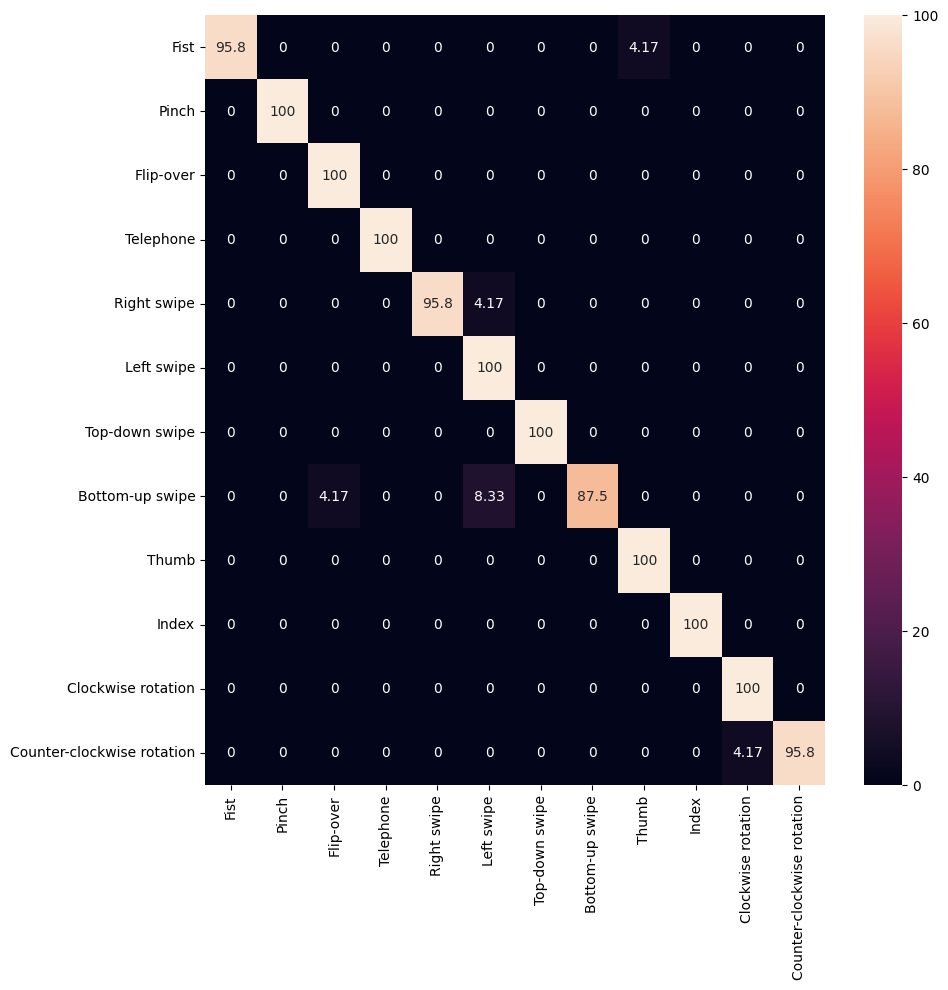

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(true_labels, pred_labels, normalize='true')*100, ax=ax, annot=True, fmt='.3g', xticklabels=briareo_labels, yticklabels=briareo_labels)
plt.show()

### ◼ **VISUALIZE**

In [ ]:
for batch in train_dataloader:
    V, y = batch
    identity = get_sgcn_identity(V.shape)
    pred, gcn_representation, normalized_spatial_adjacency_matrix, normalized_temporal_adjacency_matrix = sgcn(V, identity)
    break
    
gcn_representation.shape, normalized_spatial_adjacency_matrix.shape, normalized_temporal_adjacency_matrix.shape

In [ ]:
sns.heatmap(gcn_representation[10].detach().cpu())

In [ ]:
normalized_spatial_adjacency_matrix = normalized_spatial_adjacency_matrix.mean(dim=1)
normalized_spatial_adjacency_matrix.shape

In [ ]:
sns.heatmap(normalized_spatial_adjacency_matrix[2].detach().cpu(), xticklabels=names, yticklabels=names)

In [ ]:
normalized_temporal_adjacency_matrix = normalized_temporal_adjacency_matrix.mean(dim=1)
normalized_temporal_adjacency_matrix.shape

In [ ]:
sns.heatmap(normalized_temporal_adjacency_matrix[1].detach().cpu())